In [1]:
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from scipy.integrate import solve_ivp

In [2]:
TOTAL_TIME = 10.0
a = 1.0
b = a
c = a
d = a

#Initial values of the prey and the predator
U0 = 1.5
V0 = 1.0


class PINN(nn.Module):
    """Simple neural network accepting one feature as input and returning a single output
    
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh(), pinning: bool = False):

        super().__init__()

        self.pinning = pinning

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 2)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        #self.act = nn.ReLU() performs bad!
    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)


def f(nn_approximator: PINN, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""

    return nn_approximator(x)

""" 
def df(nn_approximator:PINN, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    df_value = f(nn_approximator, x)
    print("the shape of the df_vlaue before:", df_value.shape)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            #grad_outputs=torch.ones(x.shape[0],  2),  
            grad_outputs=torch.ones_like(df_value),  
            create_graph=True,
            retain_graph=True,
        )[0]
    print("The shape of the df value:", df_value.shape)
    return df_value
 """
def df(nn_approximator:PINN, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
  
    df_value = f(nn_approximator, x)
    #print("type of df_value on top:", type(df_value), "shape of df_value:", df_value.shape)

    df_u = df_value[:, 0].reshape(-1, 1)

    #print("df_u on top:", df_u)
    df_v = df_value[:, 1].reshape(-1, 1)

    for _ in range(order):
        df_u = torch.autograd.grad(
            df_u,
            x,
            grad_outputs= torch.ones_like(df_u), 
            create_graph=True,
            retain_graph=True,
        )[0]
        df_v = torch.autograd.grad(
            df_v,
            x,
            grad_outputs= torch.ones_like(df_v), 
            create_graph=True,
            retain_graph=True,
        )[0]
    #print("shape of df_u:", df_u.shape)
    #print("shape of df_v:", df_v.shape)

    #print("type of df_value:", type(df_value), "shape of df_value:", df_value.shape)
    return [df_u, df_v]

In [3]:
def compute_loss(
    nn_approximator:PINN, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss

    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    #print("shape of the du derivative:", df(nn_approximator, x).shape)

    #print("shape of the derivative:", df(nn_approximator, x).shape)


    #print("The shafe of the neural network output is:", f(nn_approximator, x).shape)

    interior_loss_u = df(nn_approximator, x)[0].flatten() - a * f(nn_approximator, x)[:, 0].flatten() +\
                             b * f(nn_approximator, x)[:, 0].flatten() * f(nn_approximator, x)[:, 1].flatten()

    interior_loss_v = df(nn_approximator, x)[1].flatten() - d * f(nn_approximator, x)[:, 0].flatten()*f(nn_approximator, x)[:, 1].flatten() +\
                             c * f(nn_approximator, x)[:, 1].flatten()


    F = torch.sqrt(interior_loss_u**2 + interior_loss_v**2)
    F = F**2
    del_x = (x[1:] - x[:-1]).reshape(-1)

    #using the trapezoidal rule for integration. 
    loss_interior = del_x * (F[:-1] + F[1:])/2 

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss_u = f(nn_approximator, boundary)[0] - U0
    boundary_loss_v = f(nn_approximator, boundary)[1] - V0

    boundary_loss = torch.sqrt(boundary_loss_u**2 + boundary_loss_v**2)
    boundary_loss = boundary_loss**2
    #final_loss = interior_loss.pow(2).mean() + boundary_loss_u ** 2 +\
    #    boundary_loss_v ** 2

    final_loss = F.mean() + boundary_loss.mean()
    #final_loss = torch.sum(loss_interior) + boundary_loss
    return final_loss

In [4]:
def train_model(
    nn_approximator:PINN,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> PINN:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn_approximator.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn_approximator)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn_approximator, np.array(loss_evolution)

In [5]:
def train_model(
    nn_approximator:PINN,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> PINN:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn_approximator.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn_approximator)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn_approximator, np.array(loss_evolution)

Epoch: 0 - Loss: 3.887619
Epoch: 1000 - Loss: 0.010620
Epoch: 2000 - Loss: 0.003188
Epoch: 3000 - Loss: 0.001982
Epoch: 4000 - Loss: 0.001472
Epoch: 5000 - Loss: 0.001161
Epoch: 6000 - Loss: 0.000941
Epoch: 7000 - Loss: 0.000775
Epoch: 8000 - Loss: 0.000648
Epoch: 9000 - Loss: 0.000548


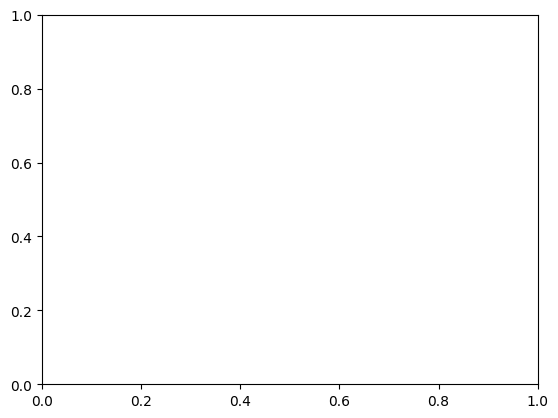

In [6]:
""" def input_transform(t):
    return torch.cat(
         [
             torch.sin(t),
         ],
         dim=1
     )
 """
from functools import partial
TOTAL_TIME = 2.0
domain = [0.0, TOTAL_TIME]
x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
x = x.reshape(x.shape[0], 1)
#x = input_transform(x)
nn_approximator = PINN(5, 50)
# f_initial = f(nn_approximator, x)
# ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)

nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=10_000
)

x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

#x = input_transform(x_eval)
# plotting

fig, ax = plt.subplots()

f_final_training = f(nn_approximator_trained, x)
f_final = f(nn_approximator_trained, x_eval)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


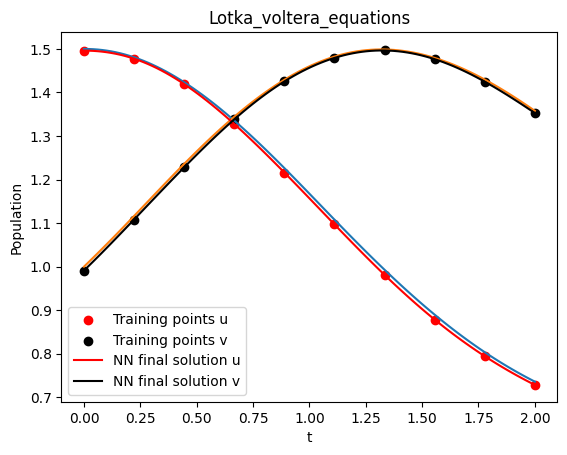

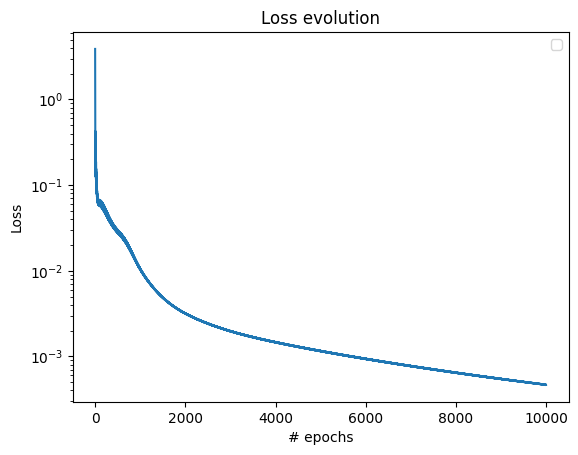

loss_evolution:  [3.8876185e+00 1.2217177e+00 2.2987090e-01 ... 4.6457147e-04 4.6866291e-04
 4.6443258e-04]
loss minimum:  0.00046443258 loss maximum: 3.8876185


In [7]:
###############PLOTTING######################
### =============Numeric Solution==========================

x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

_t = x.detach().numpy().reshape(-1)
_T = x_eval.detach().numpy().reshape(-1)

def lveqs(t, states):
    u = states[0]
    v = states[1]
    return np.array([
        a * u - b * u * v, 
        c * u * v - d * v
    ])
    # du/dt = α u - β u v
    # dv/dt = δ u v - γ v

numeric_solution = solve_ivp(lveqs, (_T[0], _T[-1]), [U0, V0], "RK45", _T)

usol = numeric_solution.y[0, :]
vsol = numeric_solution.y[1, :]
fig, ax = plt.subplots()
ax.plot(numeric_solution.t, usol)
ax.plot(numeric_solution.t, vsol)
ax.legend()
### =========================================================

# predictions from PINNS
f_final = f(nn_approximator_trained, x_eval)
ax.scatter(x.detach().numpy(), f_final_training.detach().numpy()[:, 0], label="Training points u", color="red")

ax.scatter(x.detach().numpy(), f_final_training.detach().numpy()[:, 1], label="Training points v", color="black")

ax.plot(x_eval.detach().numpy(), f_final.detach().numpy()[:, 0], label="NN final solution u", color = "red")

ax.plot(x_eval.detach().numpy(), f_final.detach().numpy()[:, 1], label="NN final solution v", color = "black")

ax.set(title="Lotka_voltera_equations", xlabel="t", ylabel="Population")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()
print("loss_evolution: ", loss_evolution)
print("loss minimum: ", min(loss_evolution), "loss maximum:", max(loss_evolution))